스위스 제네바에서 열린 제 72차 세계보건기구(World Health Organization, WHO) 총회의 국제질병분류 11차 개정판인 ICD-11.
게임이용 장애는 이 ICD-11에 질병코드 '6C51'로 등록되어 있으며, 6C51에서는 '개인, 가족 사회, 교육, 직업 또는 기타 중요한 기능 영역에서 심각한 장애를 초래할 정도로 심각하고, 이러한 게임 행동 양식이 최소 12개월 동안 분명하게 나타나는 경우'로 게임 질병을 정의하고 있다.
WHO는 현재 194개의 회원국들에게 2022년 1월부터 효력이 발생하도록 하고 있지만, 한국은 이 ICD-11를 그대로 적용하지 않고 KCD(Korean Standard Classification of Diseases, 한국표준질병)라는 독자 기준에 따라 적용 여부를 정하고 있다.
이 KCD는 5년에 한 번씩 개정되며, WHO의 코드 발효가 오는 2022년이기 때문에 국내는 3년 뒤인 2025년에 적용될 것으로 예측된다. 그동안 단 한 번도 특정 질병 코드가 적용되지 않은 사례가 없었고, 보건복지부 측에서도 이미 이 코드를 받아들이겠다는 입장을 밝힌만큼 2025년에는 정식으로 KCD에 게임이용 장애가 등록될 것으로 예측되고 있다.
국내 질병코드 등재 후 가장 사회적으로 이슈가 될 사항은 바로 '게임세'다. 게임이 '사회에 해악이 되는 질병'으로 규정된 만큼 합당한 부담금을 부과해야한다는 논리다.
연간 순매출액의 0.5% 이하 범위에서 부담금을 부과·징수할 수 있다고 되어있다.



In [4]:
from mesa import Agent
from mesa import Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt 

In [5]:
def compute_gini(model):
    agent_wealths=[agent.wealth for agent in model.schedule.agents]
    x=sorted(agent_wealths)
    N=model.num_agents
    B=sum(xi*(N-i) for i,xi in enumerate(x))/(N*sum(x))
    return (1+(1/N)-2*B)

In [27]:
def compute_paid(model):
    agent_paid=[agent.paid for agent in model.schedule.agents]
    return sum(agent_paid)

# Gamer
게임을 하는 사람을 Gamer라고 한다.
Gamer는 다음과 같은 특징을 가진다.

|특성|변수|설명|
|----|-----|-----|
|게임 몰입도|involvement|Game에 몰입하는 정도, 기본은 1|
|자산|wealth|Game에 지출할 수 있는 총 재산, 기본은 100|
|시간|tick|게임 시계, 30일마다 reset|
|지불|paid|Game에 지출한 재산(누적)|

게임을 하면 몰입도가 증가하고, 게임을 하지 않으면 몰입도가 감소된다.

질병코드가 도입되면 게임비용이 증가한다. (사회적 비용 증가)



In [57]:
WEALTH_UPPER=30 #게임에 들이는 총 재산 상한선

In [58]:
class Gamer(Agent):
    def __init__(self,unique_id,model):
        super().__init__(unique_id,model)
        self.involvement=1
        self.wealth=WEALTH_UPPER
        self.tick=0
        self.paid=0
        #members
    def step(self):
        self.tick+=1 #tick up
        self.money_fill()
        self.move()
        if self.wealth > 0:
            self.play_game()
    def money_fill(self):
        if self.tick >= 30:
            self.wealth+=self.model.money_refill
            if self.wealth >= WEALTH_UPPER:
                self.wealth=WEALTH_UPPER
            self.tick=0
    def move(self):
        possible_steps=self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )
        new_position=self.random.choice(possible_steps)
        self.model.grid.move_agent(self,new_position)
    #게임 수행 시뮬레이션.
    def play_game(self):
        cellmates=self.model.grid.get_cell_list_contents([self.pos,])
        #Game을 할 수 있다면,
        if len(cellmates)>self.model.game_party: #game type별로 수정
            other=self.random.choice(cellmates) # random.choices(cellmates,k=2) #multiple choice
            #게임 아이템 구매 동기 발생(부분 유료화), 부러움 + 동전 던지기
            if other.involvement >= self.involvement and self.random.random() <= 0.5:
                reduced=model.game_cost+model.tax
                if (self.wealth-reduced) < 0:
                    reduced=self.wealth
                self.paid+=model.game_cost #세금은 게임사에 귀속되지 않음
                self.wealth-=reduced #게이머의 재산 감소(게임사 수익+세금)
                self.involvement+=1
            #active 하게 게임을 해서 involvment가 증가
            self.involvement+=1
        #Game을 할 수 없다면,
        else:
            if self.random.random() <= 0.5: #동전 던지기. 게임 흥미를 잃을 확률 50%
                self.involvement-=1
            if self.involvement <=0:
                self.involvement=0

In [48]:
class OnlineGame(Model):
    def __init__(self,N,game_party,tax,width,height):
        self.num_agents=N
        # ==== Model Parameter ====
        self.tax=tax #game cost up
        self.game_cost=1
        self.money_refill=30
        self.game_party=game_party #게임에 참여하는 사람(최소 게임을 할 수 있는 인원)
        #
        self.running=True
        self.schedule=RandomActivation(self)
        self.grid=MultiGrid(width,height,True) #set Toroidal True
        self.datacollector=DataCollector(
            #model_reporters={'Gini':compute_gini},
            agent_reporters={'Involvement':'involvement',
                            'Wealth':'wealth',
                            'Paid':'paid'}
        )
        self.setup_agent_pos()
    def setup_agent_pos(self):
        for i in range(self.num_agents):
            a=Gamer(i,self)
            self.schedule.add(a)
            x=self.random.randrange(self.grid.width)
            y=self.random.randrange(self.grid.height)
            self.grid.place_agent(a,(x,y))
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [24]:
model=OnlineGame(50,1,4,10,10)
for i in range(100):
    model.step()

In [15]:
%matplotlib inline

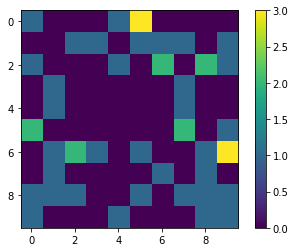

In [16]:
agent_counts=np.zeros((model.grid.width,model.grid.height))
for cell in model.grid.coord_iter():
    cell_content,x,y=cell
    agent_count=len(cell_content)
    agent_counts[x][y]=agent_count
plt.imshow(agent_counts,interpolation='nearest')
plt.colorbar()
plt.show()

In [25]:
agent_wealth=model.datacollector.get_agent_vars_dataframe()
agent_wealth.to_csv('test.csv')

In [26]:
from mesa.batchrunner import BatchRunner #배치처리.

In [61]:
fixed_params={'width':10,'height':10,'N':50,'game_party':1}
variable_params={'tax':[0,1,2,3]}
batch_run=BatchRunner(
    OnlineGame,
    variable_params, #세팅의 수는 49개 range(10,500,10), 10에서 490까지
    fixed_params,
    iterations=500,
    max_steps=90,
    model_reporters={'Paid':compute_paid}
)
batch_run.run_all()

1000it [02:01,  8.12it/s]


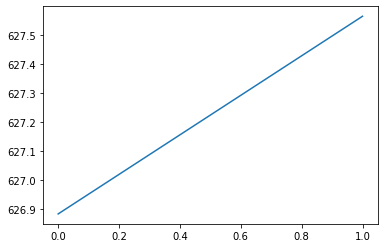

In [62]:
run_data=batch_run.get_model_vars_dataframe() #각각의 batch가 끝날 때 데이터 수집
result=run_data.groupby('tax').mean()
result=result.reset_index()
plt.plot(result.tax,result.Paid)